In [2]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group


import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor

torch.set_default_dtype(torch.float64)

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, to_undirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from torch_cluster import knn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import uproot
import vector
vector.register_awkward()
import awkward as ak

from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.1.0+cpu
PyG version 2.6.1


In [3]:
import torch
from torch_geometric.data import Data, Dataset
from scipy.spatial import cKDTree
import numpy as np
import h5py

class HGCalGraphDataset(Dataset):
    def __init__(self, h5_path, num_events=None, k=6, transform=None):
        super().__init__()
        self.k = k
        self.transform = transform
        self.data_list = []

        # Load full data
        with h5py.File(h5_path, 'r') as f:
            nhits = f['nhits'][:]
            rechit_energy = f['rechit_energy'][:]
            rechit_x = f['rechit_x'][:]
            rechit_y = f['rechit_y'][:]
            rechit_z = f['rechit_z'][:]
            target = f['target'][:]

        if num_events is not None:
            nhits = nhits[:num_events]
            target = target[:num_events]

        rechit_event_indices = np.zeros(len(nhits) + 1, dtype=np.int64)
        rechit_event_indices[1:] = np.cumsum(nhits)

        for i in range(len(nhits)):
            start, end = rechit_event_indices[i], rechit_event_indices[i + 1]

            # Get node features
            e = rechit_energy[start:end]
            x = rechit_x[start:end]
            y = rechit_y[start:end]
            z = rechit_z[start:end]

            if len(e) < 2:
                continue  # Skip graphs with <2 nodes

            # Node feature: [energy, x, y, z]
            x_node = np.stack([e, x, y, z], axis=1).astype(np.float32)

            # Edge index using KNN (on x-y)
            pos = np.stack([x, y], axis=1)
            tree = cKDTree(pos)
            edge_index_list = []

            for idx in range(len(pos)):
                dists, neighbors = tree.query(pos[idx], k=min(self.k + 1, len(pos)))
                for n in neighbors[1:]:  # skip self
                    edge_index_list.append([idx, n])

            edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
            x_node = torch.tensor(x_node, dtype=torch.float)
            y_event = torch.tensor([target[i]], dtype=torch.float)

            data = Data(x=x_node, edge_index=edge_index, y=y_event)
            self.data_list.append(data)

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        if self.transform:
            data = self.transform(data)
        return data


In [5]:


dataset_path = '/home/debabrata/Work/ML_IISERK/Rajdeep_sir/data/'
file_name = dataset_path + 'hgcal_electron_data_0001.h5' # -- from -- "https://hqu.web.cern.ch/datasets/JetClass/example/" #
dataset = HGCalGraphDataset(h5_path=file_name,num_events=1,k=6)



: 

Max hits in an event: 1379.0
Min hits in an event: 11.0
Avg hits per event: 799.4667464679451


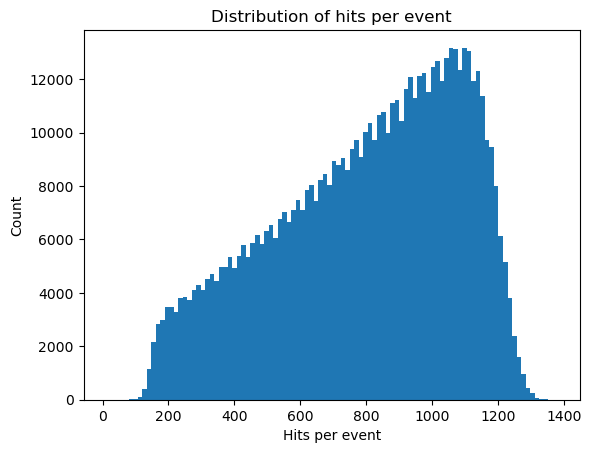

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("/home/debabrata/Work/ML_IISERK/Rajdeep_sir/data/hgcal_electron_data_0001.h5", "r") as f:
    nhits = f["nhits"][:]

print("Max hits in an event:", nhits.max())
print("Min hits in an event:", nhits.min())
print("Avg hits per event:", nhits.mean())

plt.hist(nhits, bins=100)
plt.xlabel("Hits per event")
plt.ylabel("Count")
plt.title("Distribution of hits per event")
plt.show()


In [4]:
import h5py
import numpy as np
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data

with h5py.File("/home/debabrata/Work/ML_IISERK/Rajdeep_sir/data/hgcal_electron_data_0001.h5", "r") as f:
    nhits = f["nhits"][:1].astype(int)  # Fix applied here
    rechit_energy = f["rechit_energy"][:nhits[0]]
    rechit_x = f["rechit_x"][:nhits[0]]
    rechit_y = f["rechit_y"][:nhits[0]]
    rechit_z = f["rechit_z"][:nhits[0]]
    target = f["target"][:1]

print("Hits in event 0:", nhits[0])

# Node features
x_node = np.stack([rechit_energy, rechit_x, rechit_y, rechit_z], axis=1).astype(np.float32)

# KNN edge index
pos = np.stack([rechit_x, rechit_y], axis=1)
tree = cKDTree(pos)

k = 6
edge_index_list = []
for idx in range(len(pos)):
    dists, neighbors = tree.query(pos[idx], k=min(k + 1, len(pos)))
    for n in neighbors[1:]:  # skip self
        edge_index_list.append([idx, n])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
x_node = torch.tensor(x_node, dtype=torch.float)
y = torch.tensor([target[0]], dtype=torch.float)

data = Data(x=x_node, edge_index=edge_index, y=y)
print(data)


Hits in event 0: 1115
Data(x=[1115, 4], edge_index=[2, 6690], y=[1])


In [1]:
import torch
from torch_geometric.data import Dataset, Data
import numpy as np
import h5py
from scipy.spatial import cKDTree

class HGCalGraphDataset(Dataset):
    def __init__(self, h5_path, num_events=None, k=6, max_hits=3000, use_xyz=True):
        super().__init__()
        self.k = k
        self.max_hits = max_hits
        self.use_xyz = use_xyz  # if True: build graph in x-y-z space; else x-y
        self.data_list = []

        with h5py.File(h5_path, "r") as f:
            nhits = f["nhits"][:].astype(int)
            target = f["target"][:]
            rechit_energy = f["rechit_energy"][:]
            rechit_x = f["rechit_x"][:]
            rechit_y = f["rechit_y"][:]
            rechit_z = f["rechit_z"][:]

        if num_events is not None:
            nhits = nhits[:num_events]
            target = target[:num_events]

        rechit_event_indices = np.zeros(len(nhits) + 1, dtype=np.int64)
        rechit_event_indices[1:] = np.cumsum(nhits)

        for i in range(len(nhits)):
            start, end = rechit_event_indices[i], rechit_event_indices[i + 1]
            if nhits[i] < 2 or nhits[i] > max_hits:
                continue  # skip tiny or massive events

            e = rechit_energy[start:end]
            x = rechit_x[start:end]
            y = rechit_y[start:end]
            z = rechit_z[start:end]

            # node features
            x_node = np.stack([e, x, y, z], axis=1).astype(np.float32)

            # position space for KNN
            pos = np.stack([x, y, z], axis=1) if self.use_xyz else np.stack([x, y], axis=1)

            tree = cKDTree(pos)
            edge_index_list = []
            for idx in range(len(pos)):
                dists, neighbors = tree.query(pos[idx], k=min(self.k + 1, len(pos)))
                for n in neighbors[1:]:
                    edge_index_list.append([idx, n])

            edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
            x_tensor = torch.tensor(x_node, dtype=torch.float)
            y_tensor = torch.tensor([target[i]], dtype=torch.float)

            data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
            self.data_list.append(data)

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


In [2]:
dataset = HGCalGraphDataset("/home/debabrata/Work/ML_IISERK/Rajdeep_sir/data/hgcal_electron_data_0001.h5", num_events=100, k=6, use_xyz=False)

from torch_geometric.loader import DataLoader
loader = DataLoader(dataset, num_events=10,batch_size=8, shuffle=True)

batch = next(iter(loader))
print(batch)
print("Node feature shape:", batch.x.shape)
print("Edge shape:", batch.edge_index.shape)
print("Batch size:", batch.y.shape)


: 